# DAML 09 - Trees and Forests

Michal Grochmal <michal.grochmal@city.ac.uk>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.datasets import load_wine, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
wine = load_wine()
print(wine['DESCR'])

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

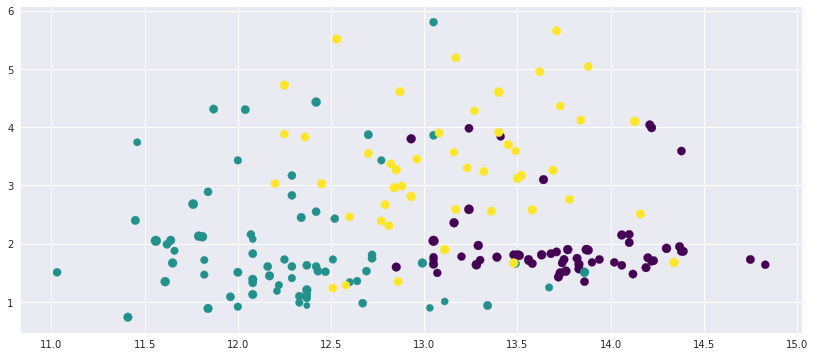

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(wine.data[:, 0], wine.data[:, 1], s=30*wine.data[:, 2], c=wine.target, cmap='viridis');

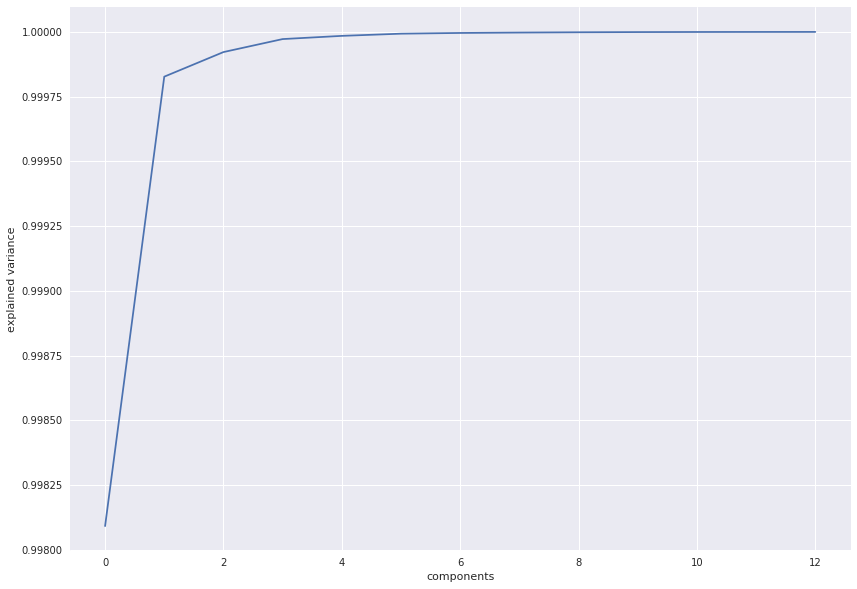

In [5]:
pca = PCA()
pca.fit(wine.data)
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set(xlabel='components', ylabel='explained variance');

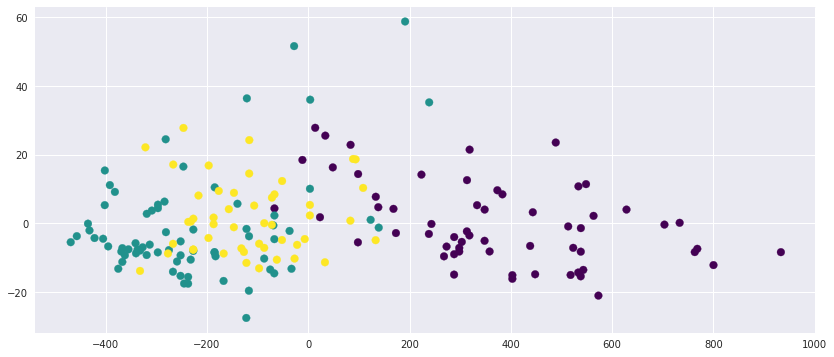

In [6]:
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine.data)
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis');

Despite the fact that we did dimensionality reduction the data does not look separable.
Let's try something different, let's describe this data using `pandas`:

In [7]:
df = pd.DataFrame(wine.data, columns=[wine.feature_names])
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


The values of *magnesium* and *proline* have completely different magnitudes from all other features.
Instead of finding the main variance in the data PCA is simply finding these two features.
Let's scale those things down and then apply PCA.

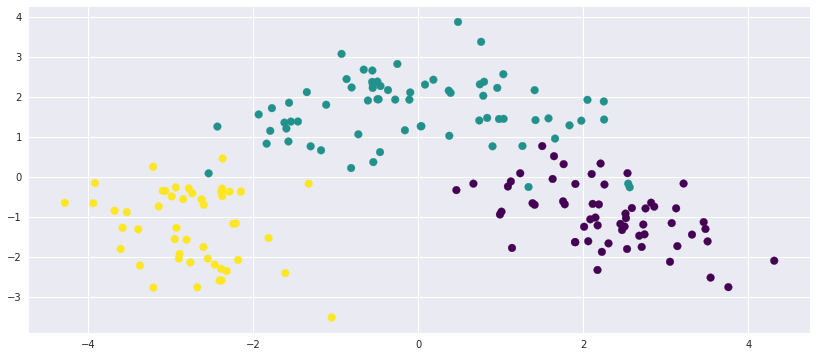

In [8]:
preprocess = make_pipeline(StandardScaler(), PCA(n_components=2))
wine_pca = preprocess.fit_transform(wine.data)
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis');

In [9]:
model = DecisionTreeClassifier()
model.fit(wine_pca, wine.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

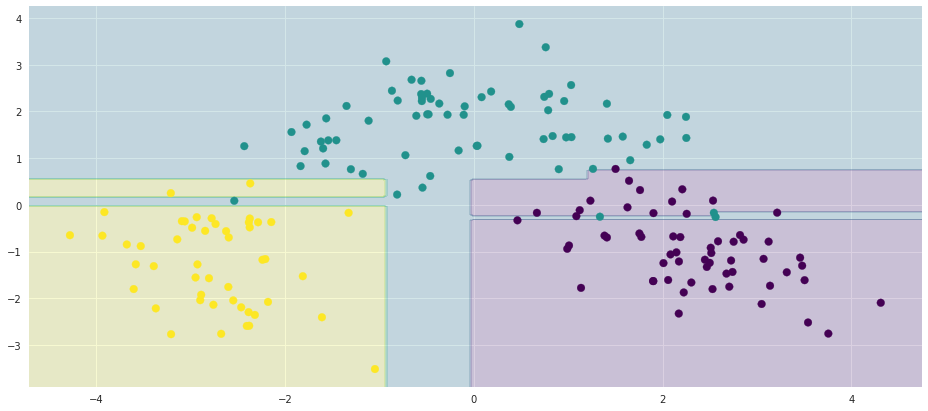

In [10]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis', zorder=2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x = np.linspace(*xlim, num=200)
y = np.linspace(*ylim, num=200)
xx, yy = np.meshgrid(x, y)
z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax.contourf(xx, yy, z, alpha=0.2, cmap='viridis', zorder=1);

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(wine_pca, wine.target, test_size=0.2)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
print('cross validation', cross_val_score(model, xtrain, ytrain))
print('test score', model.score(xtest, ytest))

cross validation [ 0.95833333  0.95833333  0.93478261]
test score 0.888888888889


A decision tree has the bad habit of overfitting the data.
But training several trees and then bagging them together makes up for it.
Such ensembles are some of the most powerful classifiers, these can draw very
fluid decision boundaries between several classes at once.

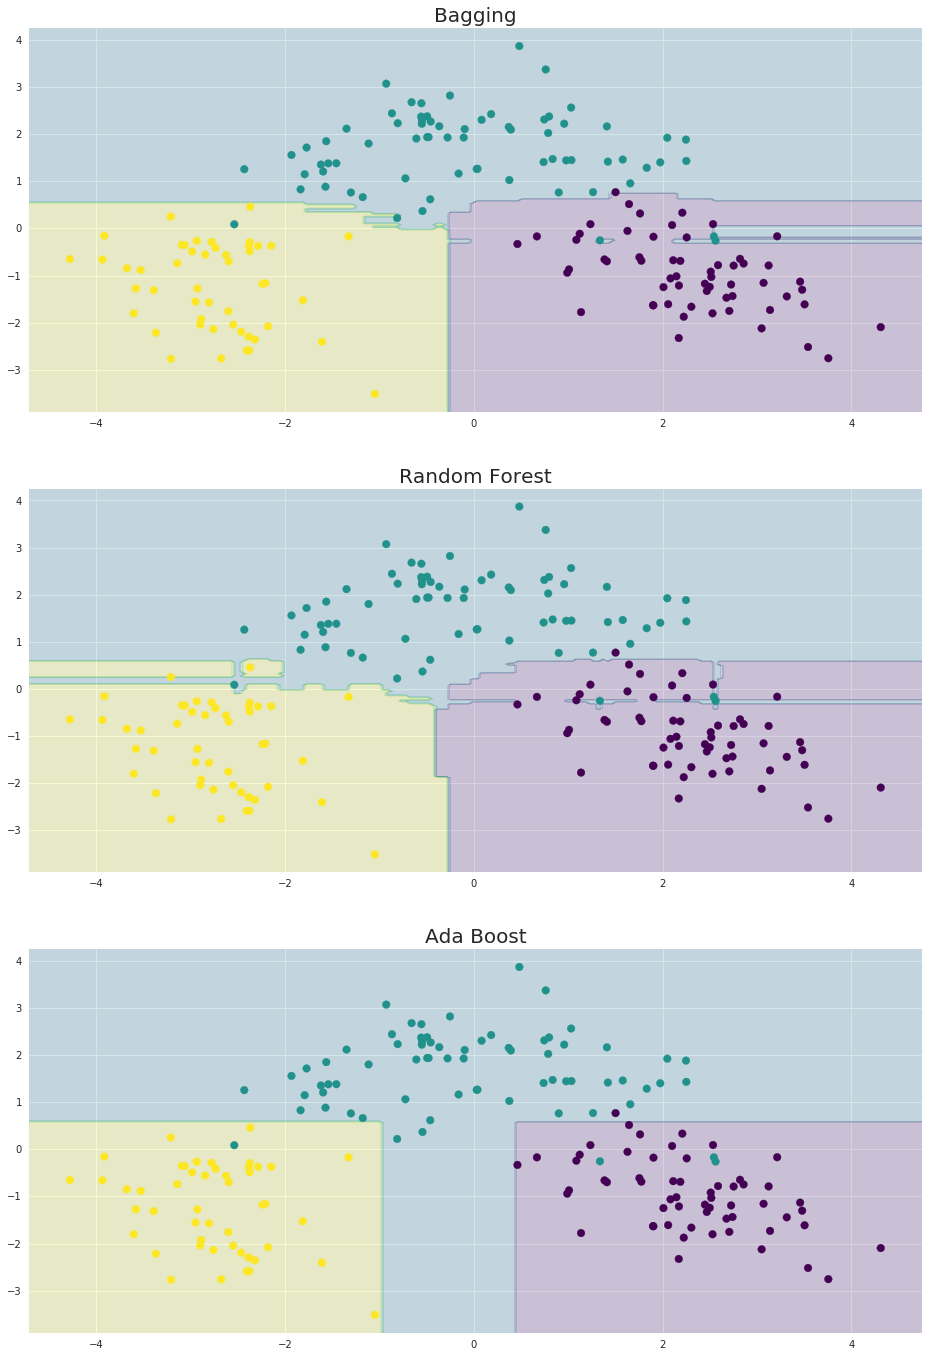

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(wine_pca, wine.target, test_size=0.2)
models = ['Bagging', 'Random Forest', 'Ada Boost']
model_dict = {
    'Bagging': BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, max_samples=0.7),
    'Random Forest': RandomForestClassifier(n_estimators=30),
    'Ada Boost': AdaBoostClassifier(n_estimators=30)
}
fig, ax = plt.subplots(len(models), figsize=(16, 24))
for i, model_name in enumerate(models):
    model = model_dict[model_name]
    model.fit(xtrain, ytrain)
    ax[i].scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis', zorder=2)
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    x = np.linspace(*xlim, num=200)
    y = np.linspace(*ylim, num=200)
    xx, yy = np.meshgrid(x, y)
    z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax[i].contourf(xx, yy, z, alpha=0.2, cmap='viridis', zorder=1)
    ax[i].set_title(model_name, fontsize=20)

In [13]:
model = RandomForestClassifier(n_estimators=30)
model.fit(xtrain, ytrain)
print('cross validation', cross_val_score(model, xtrain, ytrain))
print('test score', model.score(xtest, ytest))

cross validation [ 0.95833333  0.93617021  0.95744681]
test score 0.972222222222


## Back to an old dataset - Iris

Let's check out the random forest in action on a slightly more complicated dataset.
The wine dataset above has very little overlap between classes but, if you remember,
the Iris dataset has a good separation of the *setosa* flower but a big
overlap between *versicolor* and *virginica*.  A random forest should be capable
of drawing a decision boundary between the classes nevertheless.

In [14]:
iris = load_iris()
xtrain, xtest, ytrain, ytest = train_test_split(iris.data, iris.target, test_size=0.2)

In [15]:
model = RandomForestClassifier()
param_dist = {
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [1, 2, 5]
}
grid = GridSearchCV(model, param_dist, cv=5)
# this will take a few seconds
grid.fit(xtrain, ytrain)
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
grid.best_score_

0.97499999999999998

In [17]:
yfit = grid.best_estimator_.predict(xtest)
print(classification_report(ytest, yfit, target_names=iris.target_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00         9
 versicolor       0.75      0.86      0.80         7
  virginica       0.92      0.86      0.89        14

avg / total       0.91      0.90      0.90        30



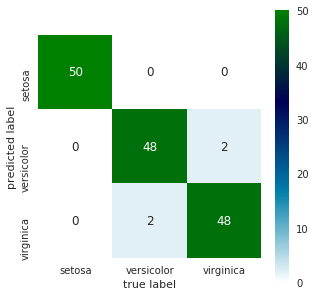

In [18]:
# this is a tiny dataset, let's look at the errors for the full data
yfit_train = grid.best_estimator_.predict(xtrain)
m = confusion_matrix(np.hstack([ytrain, ytest]), np.hstack([yfit_train, yfit]))
fig = plt.figure(figsize=(5, 5))
ax = sns.heatmap(m.T, square=True, annot=True, fmt='d', cmap='ocean_r',
                 xticklabels=iris.target_names, yticklabels=iris.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

And that's a pretty amazing result for a classifier.